In [71]:
from matplotlib import pyplot as plt
import numpy as np
from common_util import NogamiConductivityData,setup_axis_default,get_k_most_commmon_feature_transform
from matplotlib import rc
import warnings
from typing import List, Tuple

#ignore warnings and set preference for matplotlib styles
warnings.filterwarnings("ignore")
rc('font',**{'family':'serif','serif':['Times'],'weight': 'bold'})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])

#load data
nogami_data = NogamiConductivityData()  


### Feature Selection 

This model has the same goals and approach as discussed in the [uts_modeling.ipynb](uts_modeling.ipynb) notebook, so take a look at that first to understand the methodology.  I'll note here that that the fourth order polynomial basis is included because insepection of the residuals suggested this could improve the model fit. It's interesting that only polynomial features are chosen by the feature selection here, though this is likely in part due to not scaling the data. I've chosen not to scale the data during fitting for reasons I'll discuss later in this notebook.

In [73]:
from common_util import TransformedFeature


features = [TransformedFeature('x',lambda x: x,derivative= lambda x : np.ones_like(x)),
            TransformedFeature('log x',lambda x: np.log(x),derivative= lambda x : 1/x),
            TransformedFeature('1/x',lambda x: 1/x,derivative= lambda x : -1/x**2),
            TransformedFeature('1/x^2',lambda x: 1/x**2,derivative= lambda x : -2/x**3),
            TransformedFeature('x^0.5',lambda x: x**0.5,derivative= lambda x : 0.5*x**-0.5),
            TransformedFeature('x^2',lambda x: x**2,derivative= lambda x : 2*x),
            TransformedFeature('x^3',lambda x: x**3,derivative= lambda x : 3*x**2),
            TransformedFeature('x^4',lambda x: x**4,derivative= lambda x : 4*x**3),]


data= [nogami_data[key] for key in nogami_data.keys()]

feature_transform = get_k_most_commmon_feature_transform(data,6,input_features= features[:],scale = False)

print(f'selected features: {str(feature_transform)}')

data_transform = feature_transform.make_sklearn_transform(scale = False)

yprime = data_transform.deriv(np.array([[1200.,1500.]]).T)

selected features: ['1', 'x^3', 'x^2', 'x^4', 'x']


### Model Visualization

Unlike uniform elongation, and to some extent ultimate tensile stress, the curves are relatively well behaved. The fitted curves look pretty good.

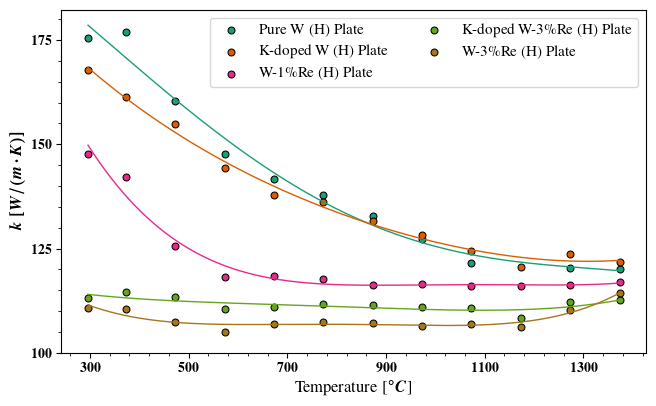

In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

fig,ax = plt.subplots(figsize = (6.5,4),ncols = 1)
setup_axis_default(ax)
for i,column in enumerate(nogami_data.keys()):
    color = i/len(nogami_data.keys())
    x,y = nogami_data[column]

    xp = np.linspace(x.min(),x.max(),1000)[:,np.newaxis]

    pipe = Pipeline([('transform',data_transform),
                     ('model',LinearRegression(fit_intercept= False))])

    pipe.fit(x,y)
    y_pred = pipe.predict(xp)
    ax.plot(xp,y_pred,lw = 1.,zorder = 100,
            color = plt.get_cmap('Dark2')(color))

    ax.scatter(x,y,s = 25,edgecolor = 'k',
            lw = 0.75,facecolor = plt.get_cmap('Dark2')(color),
            label = column.replace('%','\%'))

ax.legend(fontsize = 11,ncols = 2)



#ax.set_ylim([0,1500])
ax.set_xlabel('Temperature [$^\circ C$]',fontsize = 12)
ax.set_xticks(np.arange(300,1400,200))
ax.set_yticks(np.arange(100,200,25))
ax.set_ylabel('$k \ [W/(m \cdot K)]$',fontsize = 12)
fig.tight_layout(pad = 0.5) 

### Residual Analysis

There still appear to be some influential points/erroneous measurements that may be distorting the shape of the model . Examining The residuals can help us identify these points.

Alloy: Pure W (H) Plate | Data Length: 11
possible leverage points: []
possible outliers:
	index: [1]
	studentized residuals: [2.4589673]

--------------------------------------------


Alloy: K-doped W (H) Plate | Data Length: 12
possible leverage points: []
possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------


Alloy: W-1%Re (H) Plate | Data Length: 12
possible leverage points: []
possible outliers:
	index: [1]
	studentized residuals: [2.78946493]

--------------------------------------------


Alloy: K-doped W-3%Re (H) Plate | Data Length: 12
possible leverage points: []
possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------


Alloy: W-3%Re (H) Plate | Data Length: 12
possible leverage points: []
possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------




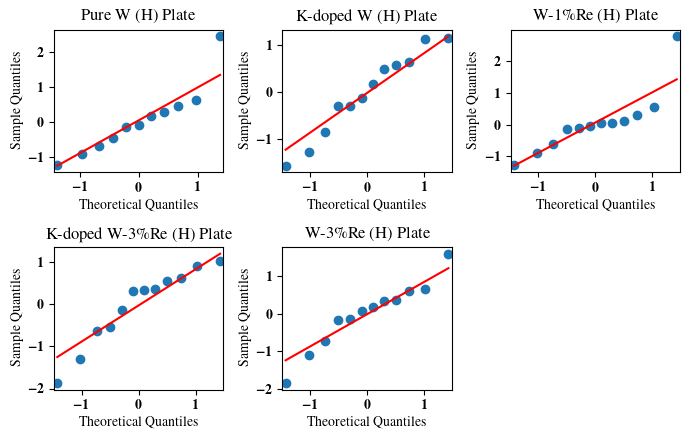

In [75]:
from statsmodels.graphics.gofplots import qqplot
import scipy

fig,axes = plt.subplots(figsize = (7,4.5),nrows = 2,ncols = 3)
               
for column,ax in zip(nogami_data.keys(),axes.ravel()):
    label = column.replace('%','\%')
    ax.set_title(label) 

    x,y = nogami_data[column]

    #make model-data transform pipeline
    pipe = Pipeline([('transform',data_transform),
                        ('model',LinearRegression(fit_intercept= False))])

    pipe.fit(x,y)
    
    #post-porcessing to get diagnostic information
    resid = y - pipe.predict(x)
    X = pipe.named_steps['transform'].transform(x)
    n,p = X.shape
    H = X @ scipy.linalg.pinvh(X.T @ X) @ X.T
                                                                                 

    S2 = np.sum(resid**2)/(n - p)
    S2_i = (n - p)/(n- p - 1)*S2 - 1/(n-p -1)*resid**2/(1 - np.diag(H))
    studentized_residuals = resid/np.sqrt(S2_i*(1 - np.diag(H)))
    leverage = np.diag(H)
    leverage_points = leverage > 2*(X.shape[1] + 1)/X.shape[0]
    
    #print informatoin about potential misfits of data for each data set
    print(f'Alloy: {column} | Data Length: {n}')
    print(f'possible leverage points: {np.arange(0,X.shape[0])[leverage_points]}')
    possible_outliers = np.arange(X.shape[0])[np.abs(studentized_residuals) > 2.]
    
    print('possible outliers:')
    print(f'\tindex: {possible_outliers}')
    print(f'\tstudentized residuals: {studentized_residuals[possible_outliers]}')

    print('\n--------------------------------------------\n\n')
    
    #qqplots
    qqplot(studentized_residuals,ax = ax,line = 's',
        color = 'blue')

axes[-1,-1].axis('off')

fig.tight_layout()

### Removing Potential Outliers and Re-Fitting the Model

There's only one apparent problem point for the pure W conductivity data, which is pretty obviously apparent in the initial plotting of the models. We'll eliminate this point and also plot the studentized residuals _vs._ fitted values $\hat{y}$ to see if there's any additional problems with the model form. 

This improves the model fit for the W model significantly. When the fourth order term is ommitted from the model, the K-doped 3\%Re W conductivity data exhibits a rather unusual residual vs. $\hat{y}$ pattern despite omission of some problem points. 

As it is now, the residuals look pretty good.

Alloy: Pure W (H) Plate | Data Length: 10
possible leverage points: []
possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------


Alloy: K-doped W (H) Plate | Data Length: 12
possible leverage points: []
possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------


Alloy: W-1%Re (H) Plate | Data Length: 10
possible leverage points: []
possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------


Alloy: K-doped W-3%Re (H) Plate | Data Length: 10
possible leverage points: []
possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------


Alloy: W-3%Re (H) Plate | Data Length: 12
possible leverage points: []
possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------




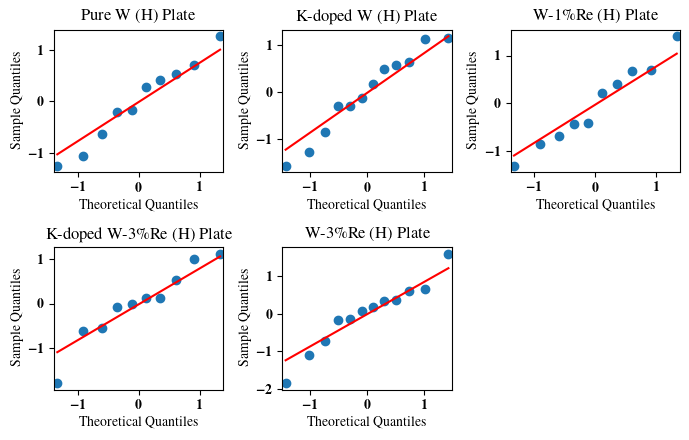

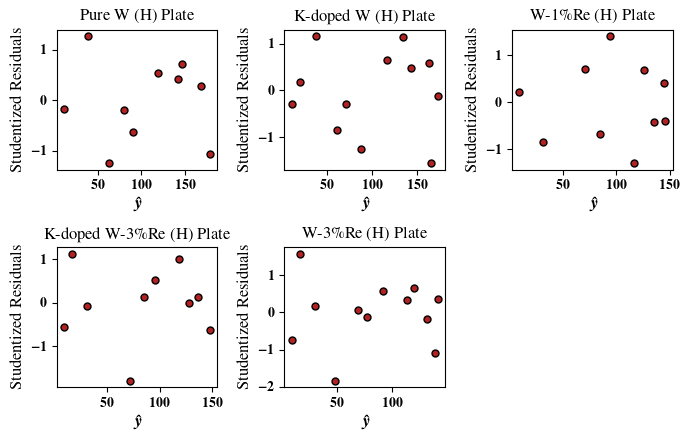

In [76]:
from statsmodels.graphics.gofplots import qqplot
import scipy

def clean_data(x: np.ndarray,y: np.ndarray,remove_points: List[int]):
    mask = np.ones_like(x.squeeze(),dtype = bool)
    mask[remove_points] = False
    return x[mask],y[mask]

fig,axes = plt.subplots(figsize = (7,4.5),nrows = 2,ncols = 3)
fig2,axes2 = plt.subplots(figsize = (7,4.5),nrows = 2,ncols = 3)

remove_data = {'Pure W (H) Plate': [1],
               'K-doped W-3%Re (H) Plate':[3,11],
               'W-1%Re (H) Plate': [1,3]}

for column,ax,ax2 in zip(nogami_data.keys(),axes.ravel(),axes2.ravel()):
    label = column.replace('%','\%')
    ax.set_title(label)
    ax2.set_title(label)    

    x,y = nogami_data[column]

    if column in remove_data:
        x,y = clean_data(x,y,remove_data[column])
    

    #make model-data transform pipeline
    pipe = Pipeline([('transform',data_transform),
                        ('model',LinearRegression(fit_intercept= False))])

    pipe.fit(x,y)
    
    #post-porcessing to get diagnostic information
    resid = y - pipe.predict(x)
    X = pipe.named_steps['transform'].transform(x)
    n,p = X.shape
    H = X @ scipy.linalg.pinvh(X.T @ X) @ X.T

    S2 = np.sum(resid**2)/(n - p)
    S2_i = (n - p)/(n- p - 1)*S2 - 1/(n-p -1)*resid**2/(1 - np.diag(H))
    studentized_residuals = resid/np.sqrt(S2_i*(1 - np.diag(H)))
    leverage = np.diag(H)
    leverage_points = leverage > 2*(X.shape[1] + 1)/X.shape[0]
    
    #print informatoin about potential misfits of data for each data set
    print(f'Alloy: {column} | Data Length: {n}')
    print(f'possible leverage points: {np.arange(0,X.shape[0])[leverage_points]}')
    possible_outliers = np.arange(X.shape[0])[np.abs(studentized_residuals) > 2.0]
    
    print('possible outliers:')
    print(f'\tindex: {possible_outliers}')
    print(f'\tstudentized residuals: {studentized_residuals[possible_outliers]}')

    
    
    #plot residuals against predicted values and qqplots
    qqplot(studentized_residuals,ax = ax,line = 's',
        color = 'blue')
    ax2.scatter(H @ y,studentized_residuals,edgecolor = 'k',
                facecolor = 'firebrick',s = 25)
    ax2.set_ylabel('Studentized Residuals',fontsize = 12)
    ax2.set_xlabel('$\hat{y}$',fontsize = 12)

    
    print('\n--------------------------------------------\n\n')

for axs in [axes,axes2]:
    axs[-1,-1].axis('off')

fig.tight_layout()
fig2.tight_layout()

### Re-checking the Feature Selection

It seems like omitting the points shown above doesn't change the selected features.

In [77]:
data= [clean_data(*nogami_data[key], remove_data[key]) if key in remove_data 
       else nogami_data[key] for key in nogami_data.keys()]

features = [TransformedFeature('x',lambda x: x),
            TransformedFeature('log x',lambda x: np.log(x)),
            TransformedFeature('1/x',lambda x: 1/x),
            TransformedFeature('x^0.5',lambda x: x**0.5),
            TransformedFeature('x^2',lambda x: x**2),
            TransformedFeature('x^3',lambda x: x**3),
            TransformedFeature('x^4',lambda x: x**4)]

feature_transform = get_k_most_commmon_feature_transform(data,4,input_features= features[:],scale = False)
print(str(feature_transform))

['1', 'x^3', 'x^2', 'x^4', 'x']


### Variability Across Alloys

We can now fit the OLS model on the transformed feature set for each alloy. We'll then sample the predictive distribution, to get upper and lower confidence bounds on the conductivity as a function of temperature. 

In [78]:
def sample_linear_predictive(Xnew: np.ndarray,
                             XtX_inv: np.ndarray,
                             dof: int,
                             S2: float,
                             n: int) -> Tuple[np.ndarray,np.ndarray]:

    return S2**0.5*np.sqrt(1. +  np.sum(Xnew.T*(XtX_inv @ Xnew.T),axis = 0))[:,np.newaxis]*scipy.stats.t.rvs(dof,size = (1,n))

xnew= np.linspace(300,1300,1000)[:,np.newaxis]
posterior_samples = []
alloy_conductivity = dict.fromkeys(nogami_data.keys())

for column in nogami_data.keys():
    if column in remove_data:
        x,y = clean_data(*nogami_data[column], remove_data[column])
    else:
        x,y = nogami_data[column]
    
    pipe = Pipeline([('transform',data_transform),
                     ('model',LinearRegression(fit_intercept= False))])
    
    pipe.fit(x,y)
    resid = pipe.predict(x) - y
    
    X = pipe.named_steps['transform'].transform(x)
    Xp = pipe.named_steps['transform'].transform(xnew)

    S2 = np.sum(resid**2)/(X.shape[0] - X.shape[1])
    
    xtX_inv = scipy.linalg.pinvh(X.T @ X)
    yhat  = pipe.predict(xnew)
    alloy_conductivity[column]  = yhat.copy()
    posterior_samples.append(
        yhat[:,np.newaxis] + sample_linear_predictive(Xp,xtX_inv,X.shape[0] - X.shape[1],S2,1000)
    )

    print(f'{column}: R2: {round(pipe.score(x,y),4)} | std. dev.: {round(S2**0.5,2)}')

posterior_samples = np.concatenate(posterior_samples,axis = 1)
low_uts,high_uts = np.percentile(posterior_samples,[2.5,97.5],axis = 1)
mean_uts = np.mean(posterior_samples,axis = 1)

Pure W (H) Plate: R2: 0.9938 | std. dev.: 1.95
K-doped W (H) Plate: R2: 0.9916 | std. dev.: 1.85
W-1%Re (H) Plate: R2: 0.9986 | std. dev.: 0.49
K-doped W-3%Re (H) Plate: R2: 0.8278 | std. dev.: 0.7
W-3%Re (H) Plate: R2: 0.8825 | std. dev.: 1.11


### Visualizing Important Conductivity Functions.

For future analysis, we'd like to select specific curves of interest that have intrinsic meaning. To that end, there are four conductivity functions we care about: 

1. The expected value of the K-W3\%Re Plate (L) alloy.
2. The expected value of the Pure W alloy. 
3. The overall expected value across all alloys. 
4. A lower confidence interval. 
 
The pure W conductivity effectively represents the "upper confidence interval", while the K-doped 3% Re alloy is close to the lower bound on the variability in conductivity across W alloys (including inter model variance).

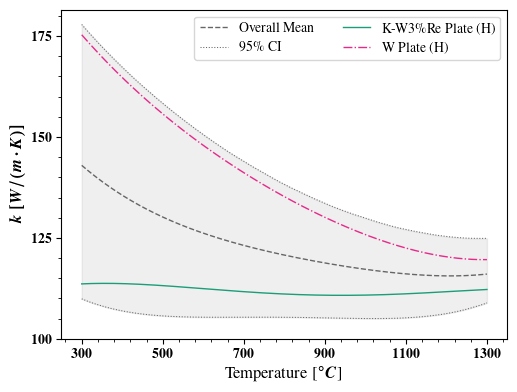

In [79]:
fig,ax = plt.subplots(figsize = (5,3.75))
setup_axis_default(ax)
ax.set_xlabel('Temperature [C]',fontsize = 12)
ax.set_ylabel('Conductivity [\%]',fontsize = 12)

sum_color = plt.get_cmap('Dark2')(0.9)
ax.plot(xnew,mean_uts,lw = 1.,zorder = 100,color = sum_color,ls = '--',label = 'Overall Mean')
ax.plot(xnew,low_uts,lw = 0.75,color  = sum_color,ls = ':',label = '95\% CI') 
ax.plot(xnew,high_uts,lw = 0.75,color  = sum_color,ls = ':')
ax.fill_between(xnew[:,0],low_uts,high_uts,color = sum_color,alpha = 0.1)

labels = {'K-doped W-3%Re (H) Plate':'K-W3\%Re Plate (H)',
          'Pure W (H) Plate': 'W Plate (H)'}

for alloy,color,ls in zip(labels,plt.get_cmap('Dark2')([0.1,0.4]),['-','-.']):
    ax.plot(xnew,alloy_conductivity[alloy],lw = 1.,zorder = 100,color = color,
            label = labels[alloy],ls = ls)

ax.legend(fontsize = 10,ncols = 2)  
ax.set_xlabel('Temperature [$^\circ C$]',fontsize = 12)
ax.set_xticks(np.arange(300,1400,200))
ax.set_yticks(np.arange(100,200,25))
ax.set_ylabel('$k \ [W/(m \cdot K)]$',fontsize = 12)

fig.tight_layout(pad = 0.1)

### Final Visualizations over the Data

Finally, let's visualize these four functions over the whole gathered dataset of conductivity. The "overall mean" falls close to the Hust-Lankford Model, while the fit to the pure W data is very optimistic compared to most other results. On the other end of things, the fitted lower bound is close to the model provided by ITER MPH for WL10. 

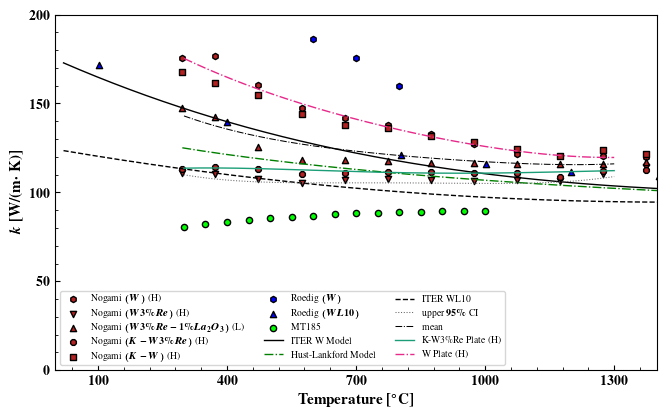

In [80]:
import pickle

with open('.scratch/conductivity_data_fig.pkl','rb') as f:
    data = pickle.load(f)
    fig,ax = data

sum_color = plt.get_cmap('Dark2')(0.9)
ax.plot(xnew,low_uts,lw = 0.75,color  = sum_color,ls = ':',label = 'upper $95\%$ CI') 
ax.plot(xnew,mean_uts,lw = 0.75,color  = 'k',ls = '-.',label = 'mean') 

labels = {'K-doped W-3%Re (H) Plate':'K-W3\%Re Plate (H)',
          'Pure W (H) Plate': 'W Plate (H)'}

for alloy,color,ls in zip(labels,plt.get_cmap('Dark2')([0.1,0.4]),['-','-.']):
    ax.plot(xnew,alloy_conductivity[alloy],lw = 1.,zorder = 100,color = color,
            label = labels[alloy],ls = ls)

ax.legend(fontsize = 7,ncols = 3)  
fig.tight_layout(pad = 0.1)
fig.savefig('images/conductivity_data_fit.svg')

### Application Practicalities

We'll use this conductivity model to inform thermal-fluid simulations. Unfortunately, the simulations need acess to the conductivity values at extremely high temperatures ($\sim 2000 ^\circ C$), substantially beyond the range of the data provided here. The Hust-Lankford model is for pure $W$ and is valid up until near the melting temperature, $\sim 3000 ^\circ C$. 

Motivated by the fact that the conductivity values appear to be converging towards a common value at higher temperatures, we can meld the fitted models with the Hust-Lankford model using a piecewise fit to the data. That is, the conductivity $k(T)$ is:

$$
k(T) = \begin{cases} 
f(T) \qquad & 300 ^\circ C \leq T \leq 1300 ^\circ C \\ 
p(T) \qquad & 1300 ^\circ C < T \leq 1500 ^\circ C \\ 
h(T) \qquad & T > 1500 ^\circ C
\end{cases}
$$

where $f(T)$ is the fitted function for a particular alloy, $h(T)$ is the Hust-Lankford model, and $p(T) \in \mathbb{P}^r$ is a "bridging polynomial" of degree $r$. We'll enforce consistency of the value and derivative of the bridging polynomial with $f$ and $h$ on the respective ends of the bridging temperature interval. The minimum polynomial order that permits this is a polynomial of degree 3, that is:

$$
p(T) = c_0 + c_1 T + c_2 T^2 + c_3 T^3 \\ 
p^\prime(T) = c_1 + 2 c_2 T + 3 c_3 T^2
$$

The equality value constraints mean that at $T_1 = 1300 ^\circ C, T_2 = 1500 ^\circ C$:

$$
p(T_1) = f(T_1) = c_0 + c_1 T_1 + c_2 T_1^2 + c_3 T_1^3 \\
p(T_2) = h(T_2) = c_0 + c_1 T_2 + c_2 T_2^2 + c_3 T_2^3
$$

whilst the derivate requirements demand that: 

$$
p^\prime (T_1) = f^\prime(T_1) = c_1 + 2 c_2 T_1 + 3 c_3 T_1^2 \\
p^\prime(T_2) = h^\prime(T_2) = c_1 + 2 c_2 T_2 + 3 c_3 T_2^2
$$

which yields the following linear system:

$$
\begin{bmatrix} 
1 & T_1 & T_1^2 & T_1^3 \\ 
1 & T_2 & T_2^2 & T_2^3 \\ 
0 & 1 & 2 T_1 & 3 T_1^2 \\ 
0 & 1 & 2 T_2 & 3 T_2^2
\end{bmatrix} \begin{bmatrix} c_0 \\ c_1 \\ c_2 \\ c_3 \end{bmatrix} = \begin{bmatrix} f(T_1) \\ h(T_2) \\ f^\prime(T_1) \\ h^\prime(T_2) \end{bmatrix}
$$

Which we can solve for the coefficients $\mathbf{c} \in \mathbb{R}^4$

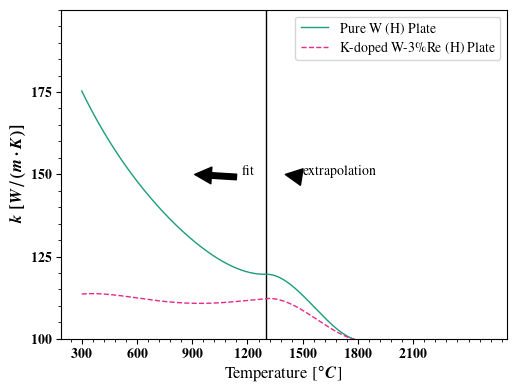

In [87]:
from numpy.polynomial import Polynomial
from typing import Callable

def get_sklearn_lm_deriv(pipe: Pipeline) -> np.ndarray:

    def derivative(Xnew: np.ndarray) -> np.ndarray:
        tform = pipe.named_steps['transform'].deriv(Xnew)
        return tform @ pipe.named_steps['model'].coef_

    return derivative

def hl_model(x: np.ndarray) -> np.ndarray:
    poly_hl = Polynomial([137.976060119897,-0.03859083192697,1.19769362e-5,-1.484e-9])
    return poly_hl(x) + 3.866e6/(x + 273.15)**2

def hl_model_deriv(x: np.ndarray) -> np.ndarray:
    poly_hl = Polynomial([137.976060119897,-0.03859083192697,1.19769362e-5,-1.484e-9])
    return poly_hl.deriv()(x) - 2*3.866e6/(x + 273.15)**3


class StichPolynomialSplineModel:

    def __init__(self,model: Callable,
                      model_deriv: Callable) -> None:
        
        self.model = model
        self.model_deriv = model_deriv
        self.poly = None
        self.break_points = None

    def fit(self, break_points: np.ndarray):
        self.break_points = break_points    
        A= np.zeros((4,4))
        A[0:2,:] = np.concatenate([break_points**r for r in range(4)],axis = 1)
        A[2:,:] = np.concatenate([np.zeros_like(break_points)] + [r*break_points**(r-1) for r in range(1,4)],axis = 1)
        b = np.zeros(4)
        b[2] = self.model_deriv(break_points[0:1,:])
        b[3] = hl_model_deriv(break_points[1:,:])
        b[0] = self.model(break_points[0:1,:])
        b[1] = hl_model(break_points[1:,:])
        self.poly = Polynomial(np.linalg.solve(A,b).squeeze())
    
    def __call__(self,x: np.ndarray) -> np.ndarray:
        y = np.zeros_like(x).squeeze()
        mask = x[:,0] <= self.break_points[0]
        y[mask] = self.model(x[mask,...])
        mask = np.all([x > self.break_points[0],x < self.break_points[1]],axis = 0).squeeze()
        y[mask] = self.poly(x[mask].squeeze())
        mask = np.squeeze(x >= self.break_points[1])
        y[mask] = hl_model(x[mask,...].squeeze())
        return y
    

columns = ['Pure W (H) Plate','K-doped W-3%Re (H) Plate']

T_eval = np.array([1300.,1800.])[:,np.newaxis]    


xplot = np.linspace(300,2500,1000)[:,np.newaxis]    

fig,ax = plt.subplots(figsize = (5,3.75))   
setup_axis_default(ax)
for column,ls,color in zip(columns,['-','--'],plt.get_cmap('Dark2')([0.1,0.4])):
    if column in remove_data:
        x,y = clean_data(*nogami_data[column], remove_data[column])
    else:
        x,y = nogami_data[column]
    
    pipe = Pipeline([('transform',data_transform),
                     ('model',LinearRegression(fit_intercept= False))])
    
    pipe.fit(x,y)
    splined_model = StichPolynomialSplineModel(pipe.predict,
                                              get_sklearn_lm_deriv(pipe))
    splined_model.fit(T_eval)
    
    ax.plot(xplot,splined_model(xplot),lw = 1.,zorder = 100,ls = ls,color = color,
            label = column.replace('%','\%'))
                

ax.set_xlabel('Temperature [$^\circ C$]',fontsize = 12)
ax.set_xticks(np.arange(300,2200,300))
ax.set_yticks(np.arange(100,200,25))
ax.set_ylabel('$k \ [W/(m \cdot K)]$',fontsize = 12)

ax.annotate('extrapolation', xy=(1400, 150), xytext=(1700, 150),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=10, ha='center',xycoords = 'axes points')

ax.annotate('fit', xy=(900, 150), xytext=(1200, 150),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=10, ha='center',xycoords = 'axes points')

ax.axvline(1300,lw = 1.,ls = '-',color = 'k')
ax.legend(fontsize = 10,ncol = 1)
ax.set_ylim([100,200])
fig.tight_layout(pad = 0.1)

    




In [40]:
import sympy 

T = sympy.symbols('T')
hl_model = 149.441 - 45.466e-3*(T + 273.15) + 13.193e-6*(T + 273.15)**2 - 1.484e-9*(T + 273.15)**3
print(sympy.simplify(hl_model))

(-1.98898492375563e-14*T**5 + 1.49659414812892e-10*T**4 - 4.31016709247899e-7*T**3 + 0.00157868975412814*T**2 + 0.971667708215054*T + 189.791529899137)/(1.34028633676256e-5*T**2 + 0.00732198425773385*T + 1.0)
